In [1]:
## imports
## see environment.yml 

import dask
import fsspec
import gc
import glob
import intake
import requests

import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

from collections import defaultdict
from __future__ import print_function
from matplotlib import pyplot as plt
from params import allnames

import xml.etree.ElementTree as ET

from dask.diagnostics import progress
from scipy.stats import norm
from tqdm.autonotebook import tqdm

import noresmfunctions as fct
from myfunctions import process_variable
from myfunctions import droughtindx, get_swei
from myfunctions import drop_all_bounds, open_dset, open_delayed, get_lat_name, global_mean, global_mean_60s, snotel_pipe, load_global

from params import allnames, experiment_ids, variables, years, table_ids, labels, colors
from params import homedir, savepath

## ## style ## ##
xr.set_options(display_style='html')
plt.style.use('./science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False


/tmp/ipykernel_19265/2719974009.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/c/cowherd/.conda/envs/e3smeval/share/proj failed


In [2]:
snotelmeta = pd.read_csv(homedir + 'data/snotelmeta.csv')

In [ ]:
## LOAD DATA FROM SAVED FILES FROM 00-download-anom-swei.ipynb ##

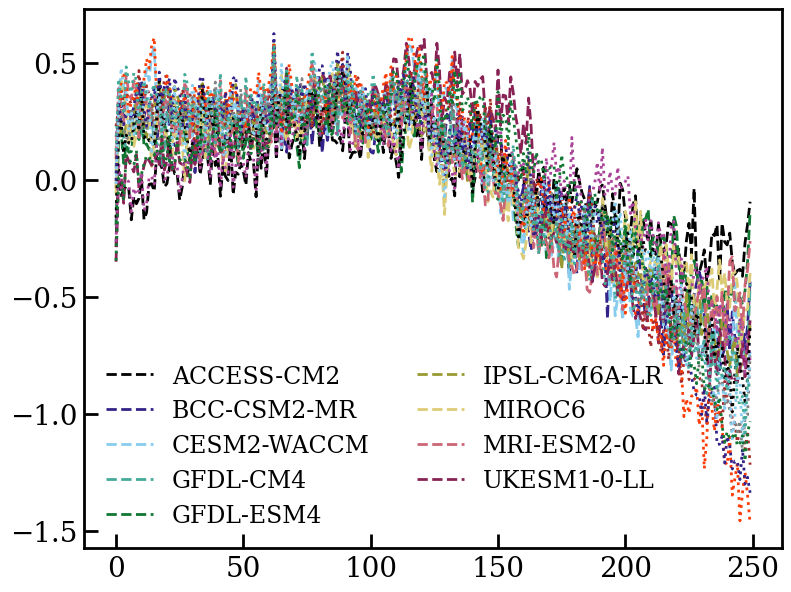

In [4]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False

import glob
fig,ax= plt.subplots(figsize = (9,7))
files = glob.glob(savepath + 'swei_*')

styles = {'585':':',
          '245':'--'}
s245lines = []
s585lines = []
for fn in sorted(files):
    model = fn.split('_')[-1][0:-4]
    if model in allnames:
        era = fn.split('_')[1][-3:]
        sweidata = np.load(fn)
        clipmean = np.nanmean(sweidata[:,:,35:,:],axis=(1,2,3)).flatten()
        if era == '585': label = None
        else: label = model
        kwargs = {'linestyle':styles[era], 'label':label} #'c':colors[model], 'label': label}
        ax.plot(clipmean, **kwargs)
        if era == '585':
            s585lines.append(clipmean)
        if era == '245':
            s245lines.append(clipmean)
ax.legend(loc = 'lower left', frameon = False, ncol = 2)
ax.tick_params(direction="in")
plt.show()


In [5]:

##
s245m = np.nanmean(np.array(s245lines), axis = 0)
s245sd = np.nanstd(np.array(s245lines), axis = 0)
s585m = np.nanmean(np.array(s585lines), axis = 0)
s585sd = np.nanstd(np.array(s585lines), axis = 0)
years = range(1850,2100)
hyears = range(1851,2015)
syears = range(2015,2098)
base245 = np.nanmean(s245m[1:51])
base585 = np.nanmean(s585m[1:51])
##


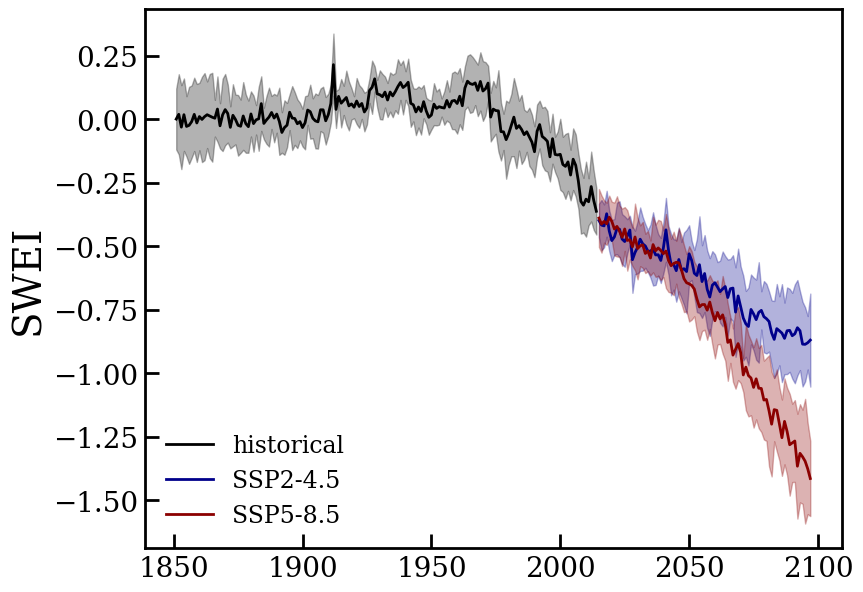

FileNotFoundError: [Errno 2] No such file or directory: './figures/fig2.jpg'

In [6]:
fig,ax= plt.subplots(figsize = (9,7))
meanhist = (s245m[1:165]-base245 + s585m[1:165]-base585)/2
sdhist = (s245sd[1:165]+ s585sd[1:165])/2
ax.plot(hyears,meanhist, colors['historical'], label = 'historical')
ax.fill_between(hyears,meanhist- sdhist, meanhist +sdhist, color = colors['historical'], alpha = 0.3)
data = s245m[165:-2]-base585
sd = s245sd[165:-2]
ax.plot(syears,s245m[165:-2]-base585,color = colors['ssp245'], label = 'SSP2-4.5')
ax.fill_between(syears, data-sd, data + sd, color = colors['ssp245'], alpha = 0.3)
data = s585m[165:-2]-1.35*base585
sd = s585sd[165:-2]
ax.plot(syears,data,colors['ssp585'], label = 'SSP5-8.5')
ax.fill_between(syears,data - sd, data +sd, color = colors['ssp585'], alpha = 0.3)
ax.legend(loc = 'lower left', frameon = False)
ax.set_ylabel('SWEI')
ax.tick_params(direction="in")
plt.show()
fig.savefig('./figures/fig2.jpg')

In [7]:
### PLOTS FOR FIG 1 ###
## load snotel data from stefan values stuff ##
#SNOTEL
snoteldir = '/global/cfs/cdirs/m4099/fate-of-snotel/snoteldata/'
file = snoteldir + "snotel_daily.txt"

ilat = -999
ilon = -999

rec_min = -70.
rec_max = 60.

ind_time = 0
ind_name = 1
ind_sitecode = 2
ind_state = 3
ind_elev = 4
ind_lat = 5
ind_lon = 6
ind_swe = 7
ind_tav = 8
ind_tmax = 9
ind_tmin = 10
ind_acc = 11
ind_prec = 12

ind_swe_qc = 13
ind_swe_qc = 15

ft2m = 12 * 2.54 / 100.
in2mm = 25.4
p49 = 49.
m100 = -100
T0 = 273.15

#Box to mask outsdie Sierra
lat_l = 35.
lat_u = 41.
lon_l = -122.5
lon_u = -116.5

read = open(file, "r")
content = read.readlines()

lat_snotel = []
lon_snotel = []
state_snotel = []
elev_snotel = []
time_snotel = []
site_snotel = []
prec_snotel = []
acc_snotel = []
swe_snotel = []
tav_snotel = []
tmin_snotel = []
tmax_snotel = []
name_snotel = []

lat_snotel_spec = []
lon_snotel_spec = []
elev_snotel_spec = []
site_snotel_spec = []

bad = -9999999
line_count = 1
lat_orig = -999. 

for line in content:
    
 if line.startswith("#") or line.startswith("Date"):
    continue

 else:
  ii = line.split(",")

  if ii[ind_state] == ii[ind_state]:
    time_snotel.append(ii[ind_time])       #Get times
    site_snotel.append(int(ii[ind_sitecode]))       #Get codes
    lat_snotel.append(float(ii[ind_lat]))
    lon_snotel.append(float(ii[ind_lon]))
    elev_snotel.append(float(ii[ind_elev])*ft2m)
    state_snotel.append(ii[ind_state])

   #SWE
    if ii[ind_swe] == "":
     swe_snotel.append(bad)
    if ii[ind_swe] != "":
     swe_x = float(ii[ind_swe])
     swe_snotel.append(swe_x)

    #Temperature
    #There are strange Tav, Tmin, and Tmax values in the data
    #We use reasonable assumptions to get rid of them
    # 1. If one is missing, eliminate them all
    # 2. Remove instances where Tmax = Tmin, Tmax = Tav, Tmax = Tmin
    # 3. Eliminate *rcords*
    
    switch = "on" #if on, raw SNOTEL data is appended
    
    #1.
    if ii[ind_tav] == "" or ii[ind_tmin] == "" or ii[ind_tmax] == "":
     tav_snotel.append(bad)
     tmax_snotel.append(bad)
     tmin_snotel.append(bad)
     switch = "off"

    if ii[ind_tav] != "" and ii[ind_tmin] != "" and ii[ind_tmax] != "":
     tav = float (ii[ind_tav])
     tmax = float (ii[ind_tmax])
     tmin = float (ii[ind_tmin])

     #2.
     dt1 = tmax - tmin
     dt2 = tmax - tav
     dt3 = tmin - tav
        
     if dt1 < 0 or dt2 < 0 or dt3 > 0:
      if switch == "on":        #This switch ensures no double-dipping
       tav_snotel.append(bad)   #"Just take one dip, and end it!!!"
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)        
       switch = "off"

     #3.
     if tmax < rec_min or tav < rec_min or tmin < rec_min:    
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)
       switch = "off"
    
     if tmax > rec_max or tav > rec_max or tmin > rec_max:
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad) 
       switch = "off"

     if switch == "on":
        tav_snotel.append(tav)
        tmax_snotel.append(tmax)
        tmin_snotel.append(tmin)

    #Acc. precip
    if ii[ind_acc] == "":
     acc_snotel.append(bad)
    if ii[ind_acc] != "":
     acc_x = float(ii[ind_acc])
     acc_snotel.append(acc_x)
    
     #Prec
    if ii[ind_prec] == "" or ii[ind_prec] == "\n":
     prec_snotel.append(bad)
    else:
     prec_mm = float(ii[ind_prec])
     prec_snotel.append(prec_mm)

    #Checks
    if float(ii[ind_lat]) != lat_orig:
     lat_snotel_spec.append(float(ii[ind_lat]))
     lon_snotel_spec.append(float(ii[ind_lon]))
     elev_snotel_spec.append(float(ii[ind_elev])*ft2m)
     site_snotel_spec.append(int(ii[ind_sitecode]))

     lat_orig =  float(ii[ind_lat])
        
snotel_day = pd.to_datetime(time_snotel, format='%Y-%m-%d')

#Convert to DataArray
swe_snotel = xr.DataArray(swe_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
prec_snotel = xr.DataArray(prec_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tave_snotel = xr.DataArray(tav_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmin_snotel = xr.DataArray(tmin_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmax_snotel = xr.DataArray(tmax_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
acc_snotel = xr.DataArray(acc_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel),
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})

#Meta array for all SNOTEL sites
meta_snotel = xr.DataArray(elev_snotel_spec,dims=['site'],coords={'site':( ['site'],site_snotel_spec), 
                                                              'lat':( ['site'],lat_snotel_spec),
                                                              'lon':( ['site'],lon_snotel_spec)})


print (len(lat_snotel_spec), len(lon_snotel_spec), len(elev_snotel_spec), len(site_snotel_spec))

print (prec_snotel)

print ("CONUS SNOTEL array generated")

gc.collect()

111 111 111 111
<xarray.DataArray (x: 577172)>
array([3., 0., 3., ..., 0., 0., 0.])
Coordinates:
    site     (x) int64 308 308 308 308 308 308 308 ... 784 784 784 784 784 784
    time     (x) datetime64[ns] 2019-09-02 2019-09-03 ... 2011-04-29 2011-04-30
    z        (x) float64 2.225e+03 2.225e+03 2.225e+03 ... 2.442e+03 2.442e+03
    state    (x) <U10 'ARIZONA' 'ARIZONA' ... 'CALIFORNIA' 'CALIFORNIA'
    lat      (x) float64 34.46 34.46 34.46 34.46 ... 39.19 39.19 39.19 39.19
    lon      (x) float64 -111.4 -111.4 -111.4 -111.4 ... -120.3 -120.3 -120.3
Dimensions without coordinates: x
CONUS SNOTEL array generated


650

In [8]:
## load globsnow data
globsnow = xr.open_dataset('../data/globsnow_no_ak.nc')
globsnow_bc = xr.open_dataset('../data/globsnow_bc_no_ak.nc')
era5 = xr.open_dataset('../data/era5_no_ak.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/global/u1/c/cowherd/snow_drought/data/globsnow_no_ak.nc'

In [ ]:
monthly_e5_mm = np.nanmean(era5.sd.data * 1000, axis =(1,2))
monthly_bc = np.nanmean(globsnow_bc.swe, axis = (1,2))
monthly = np.nanmean(globsnow.swe, axis = (1,2))


In [ ]:
monthly_bc =np.array([111.62574958, 193.22927384, 119.6392822 ,  71.65213745])
bc_nums = [2,3,4,5]
monthly_glob = np.array([2.90396489e+01, 3.04059308e+01, 1.84548280e+01, 6.69667089e+00,
       1.52255673e+00, 1.03142754e-02, 2.95057920e-03, 6.33202825e-02,
       1.37616140e+00, 1.18776219e+01])
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]

In [ ]:
fig,ax=plt.subplots()
ax.plot(monthly_glob, label = 'globsnow')
ax.plot(monthly_bc, label = 'globsnow_bc')
ax.plot(monthly_e5_mm, label = 'era5')
ax.legend()
plt.show()

In [ ]:
## just the snotel sites ##
months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(snotel_data,4),':', linewidth = 5, alpha = 1, label = 'SNOTEL')
#ax.plot(nums, np.roll(merramonthly,4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')
ax.plot(nums, np.roll(monthly_e5_mm,4), '--', c = "lightblue",linewidth = 5 , alpha = 0.5, label = 'ERA5')
# ax.plot([val + .5 for val in monthly_glob], np.roll(monthly_glob,4), '--', c = "green",linewidth = 5 , alpha = 0.5, label = 'GlobSnow')
ax.plot([5.5,6.5,7.5,8.5], np.roll(monthly_bc,4), '--', c = "red",linewidth = 5 , alpha = 0.5, label = 'GlobSnow bias-corrected')

for key in allnames:
    data = snw_snotel[key][0][0][:]
    monthly = data.groupby(data.month).mean()
    ax.plot(nums, np.roll(monthly,4), label = key, linewidth = 3)
data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
#ax.plot(nums, np.roll(data/2.54,3),'k:', linewidth = 5, alpha = 1)
#ax.plot(nums, np.roll(merramonthly,3)*4 -0.6, '--', c = "darkgray",linewidth = 10 , alpha = 1)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()
fig.savefig('./figures/fig1.jpg')

In [ ]:
## just the snotel sites ##
def minmax(data):
    return [(val- np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) for val in data]


months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(minmax(snotel_data.data),4),':',  linewidth = 5, alpha = 1, label = 'SNOTEL')
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')

for key in allnames:
    data = snw_snotel[key][0][0][:]
    monthly = data.groupby(data.month).mean()
    ax.plot(nums, np.roll(minmax(monthly),4), label = key, linewidth = 3)

ax.plot(nums, np.roll(minmax(snotel_data.data),4),':', color = 'k', linewidth = 5, alpha = 1)
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend(loc = 'upper right', fontsize = 12)
plt.show()
fig.savefig('./figures/fig1.jpg')